In [1]:
import sidechainnet as scn
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sidechainnet.dataloaders.SCNProtein import atom_name_pprint
from sidechainnet.tests.test_hydrogens import load_p, get_alias
from sidechainnet.structure import fastbuild
from sidechainnet.structure import StructureBuilder
from torch.autograd import gradcheck
from torch.autograd.functional import jacobian as get_jacobian
torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(sci_mode=False, precision=3)
np.set_printoptions(precision=3)
torch.cuda.current_device(), torch.cuda.is_available()

(0, True)

In [36]:
import importlib
importlib.reload(fastbuild)

<module 'sidechainnet.structure.fastbuild' from '/home/dkoes/git/sidechainnet/sidechainnet/structure/fastbuild.py'>

In [3]:
d = scn.load("debug",  scn_dataset=True)
p = d['70#4MMO_1_A']

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_debug.pkl.


In [4]:
p.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
%%time
p.sb = None
p.build_coords_from_angles(p.angles)

CPU times: user 11.6 s, sys: 1.47 s, total: 13 s
Wall time: 13 s


In [6]:
%%time
p.sb = None
p.build_coords_from_angles(p.angles,add_hydrogens=True)

CPU times: user 11.6 s, sys: 1.58 s, total: 13.2 s
Wall time: 13.2 s


In [7]:
%%time
sb = StructureBuilder(p.seq, ang=torch.Tensor(p.angles),device=p.device)
goodcoords = sb.build()

CPU times: user 11 s, sys: 1.4 s, total: 12.4 s
Wall time: 12.4 s


In [8]:
p.seq

'MDEELYTLIEFLKKPSISATGEGIDETANYLKETVEKLLGVKANLEKTKGHPVVYAEINVNAKKTLLIYNHYDVQPVDPISEWKRAPFSATIENDRIYARGASDNKGTLMARLFAIKHLLDKNELNVNVKLLYEGEEEIGSVNLEDYIEKNTNKLKADSVIMEGAGLDPKGRPQIVLGVKGLLYVELVLDYGTKDLHSSNAPLVRNPCIDLAKIISTLVDMGGRVLIEGFYDDVRELTEEERELIKKYDIDVEELKKALGFKELKYNEKEKIAEALLTYPTCNVDGFECGYTGKGSKTIVPHRAFAKLDFRLVPNQDPYKVFELLKKHLQKAGFNGEILAHGFEYPVRTSVNSTVVKAMIESAKKVYGTEPQVIPNSAGTQPMGLFVYKLGIRDAVSAIGAGGYYSNAHAPNENIKIDDYYKAIKHTEEFLKLYPIL'

In [9]:
from sidechainnet.structure.build_info import SC_BUILD_INFO, BB_BUILD_INFO, NUM_COORDS_PER_RES, SC_ANGLES_START_POS, NUM_ANGLES

def make_ncac(p,device='cpu'):
    '''For testing make_backbone'''
    L = len(p.seq)
    angles = p.angles
    ang = torch.zeros((L+1,SC_ANGLES_START_POS),device=device)
    ang[1:] = angles.to(device)[:L,:SC_ANGLES_START_POS] 
    ang[:,3:] = np.pi-ang[:,3:] #theta
    ang[:,:3] = 2*np.pi-ang[:,:3] #chi

    sins = torch.sin(ang)
    coss = torch.cos(ang)
    #O needs one additional angle
    schi = sins[:,:3].flatten()[1:-1]
    cchi = coss[:,:3].flatten()[1:-1]

    oschi = schi[3::3]
    occhi = cchi[3::3]
    schi = schi[:-1]
    cchi = cchi[:-1]

    stheta = sins[:,3:].flatten()[1:-2]
    ctheta = coss[:,3:].flatten()[1:-2]

    lens = torch.tensor([BB_BUILD_INFO['BONDLENS']['c-n'],BB_BUILD_INFO['BONDLENS']['n-ca'],BB_BUILD_INFO['BONDLENS']['ca-c']],device=device).repeat(L)
    lens[0] = 0 # first atom starts at origin
    ncacM = fastbuild.makeTmats(ctheta, stheta, cchi, schi, lens)

    return ncacM

In [40]:
p.torch()

In [44]:
fastbuild.sc_heavy_atom_build_info['CA']['sources'].dtype

torch.float32

In [77]:
importlib.reload(fastbuild)

angles = p.angles.detach()
genc = fastbuild.make_coords(p.seq,angles)

In [78]:
diff = (genc.cpu()-goodcoords.reshape(genc.shape)).reshape((len(p.seq),-1))
torch.nansum(diff*diff)

tensor(4.570, dtype=torch.float64, grad_fn=<NansumBackward0>)

<AxesSubplot:>

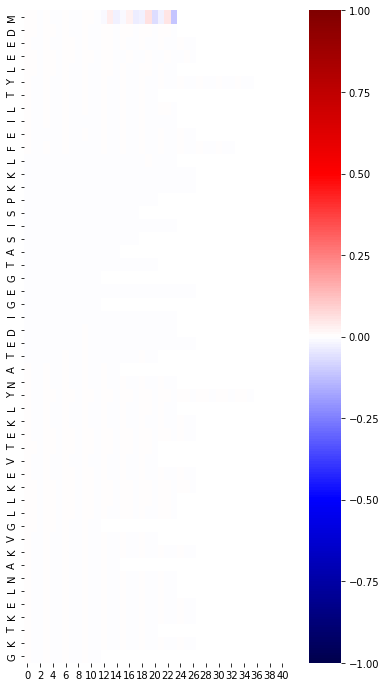

In [79]:
plt.figure(figsize=(6,12))
sns.heatmap(diff.detach().numpy()[:50],yticklabels=p.seq[:50],cmap='seismic',vmin=-1,vmax=1)

In [15]:
%%timeit
angles.requires_grad = False
genc = fastbuild.make_coords(p.seq,angles)

9.73 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
angles.requires_grad = True
genc = fastbuild.make_coords(p.seq,angles)

59.4 ms ± 87 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
angles.requires_grad = False
angles = angles.to('cuda')

In [18]:
%%timeit
genc = fastbuild.make_coords(p.seq,angles)

17.8 ms ± 9.89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
angles.requires_grad = True
angles = angles.to('cuda')

In [20]:
%%timeit
genc = fastbuild.make_coords(p.seq,angles)

63.5 ms ± 320 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
p.torch()

In [22]:
p.angles.requires_grad = True

In [23]:
sb = StructureBuilder(p.seq, ang=p.angles,device=p.device,nerf_method='standard')

In [24]:
%%timeit
goodcoords = sb.build()

20.1 s ± 53.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%time
sb.add_hydrogens()

CPU times: user 4.95 s, sys: 534 ms, total: 5.49 s
Wall time: 5.48 s


In [26]:
ncac = make_ncac(p)

In [27]:
smn = ncac.clone().detach()
smn.requires_grad = True
%time backbone = fastbuild.make_backbone_(smn.clone())
s = backbone.sum()
%time s.backward()

CPU times: user 211 ms, sys: 6.73 ms, total: 218 ms
Wall time: 23.5 ms
CPU times: user 95.4 ms, sys: 0 ns, total: 95.4 ms
Wall time: 7.83 ms


In [28]:
goodgrad = smn.grad

In [29]:
smn = ncac.clone().detach()
smn.requires_grad = True
%time backbone = fastbuild.MakeBackbone.apply(smn.clone())
s = backbone.sum()
%time s.backward()

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 6.46 ms
CPU times: user 48.8 ms, sys: 32 µs, total: 48.9 ms
Wall time: 4.92 ms


In [30]:
diff = (goodgrad-smn.grad).detach().numpy()

In [31]:
err = (diff*diff).sum(axis=(1,2))

0.12810153

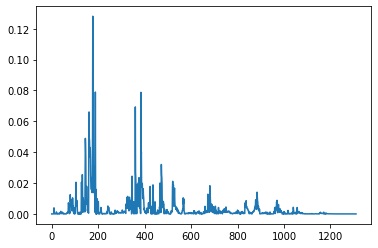

In [32]:
plt.plot(err)
err.max()

In [33]:
smn = ncac.clone().detach().double()
smn.requires_grad = True
%time backbone = fastbuild.make_backbone_(smn.clone())
s = backbone.sum()
%time s.backward()
goodgrad = smn.grad

CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 26.5 ms
CPU times: user 50.6 ms, sys: 0 ns, total: 50.6 ms
Wall time: 6.59 ms


In [34]:
smn = ncac.clone().detach().double()
smn.requires_grad = True
%time backbone = fastbuild.MakeBackbone.apply(smn.clone())
s = backbone.sum()
%time s.backward()

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 5.87 ms
CPU times: user 48.8 ms, sys: 0 ns, total: 48.8 ms
Wall time: 4.8 ms


9.657650694375753e-19

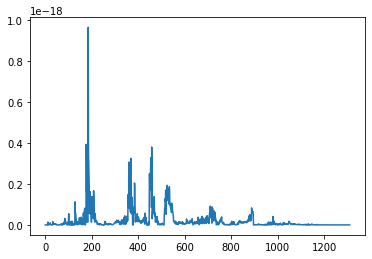

In [35]:
diff = (goodgrad-smn.grad).detach().numpy()
err = (diff*diff).sum(axis=(1,2))
plt.plot(err)
err.max()